In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Ignore deprecation warnings
import warnings
warnings.filterwarnings("ignore")

## Data Loading and Exploration

In [3]:
# Import libraries
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
# Load and analyse dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

170498071/170498071 [==============================] - 2s 0us/step
X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


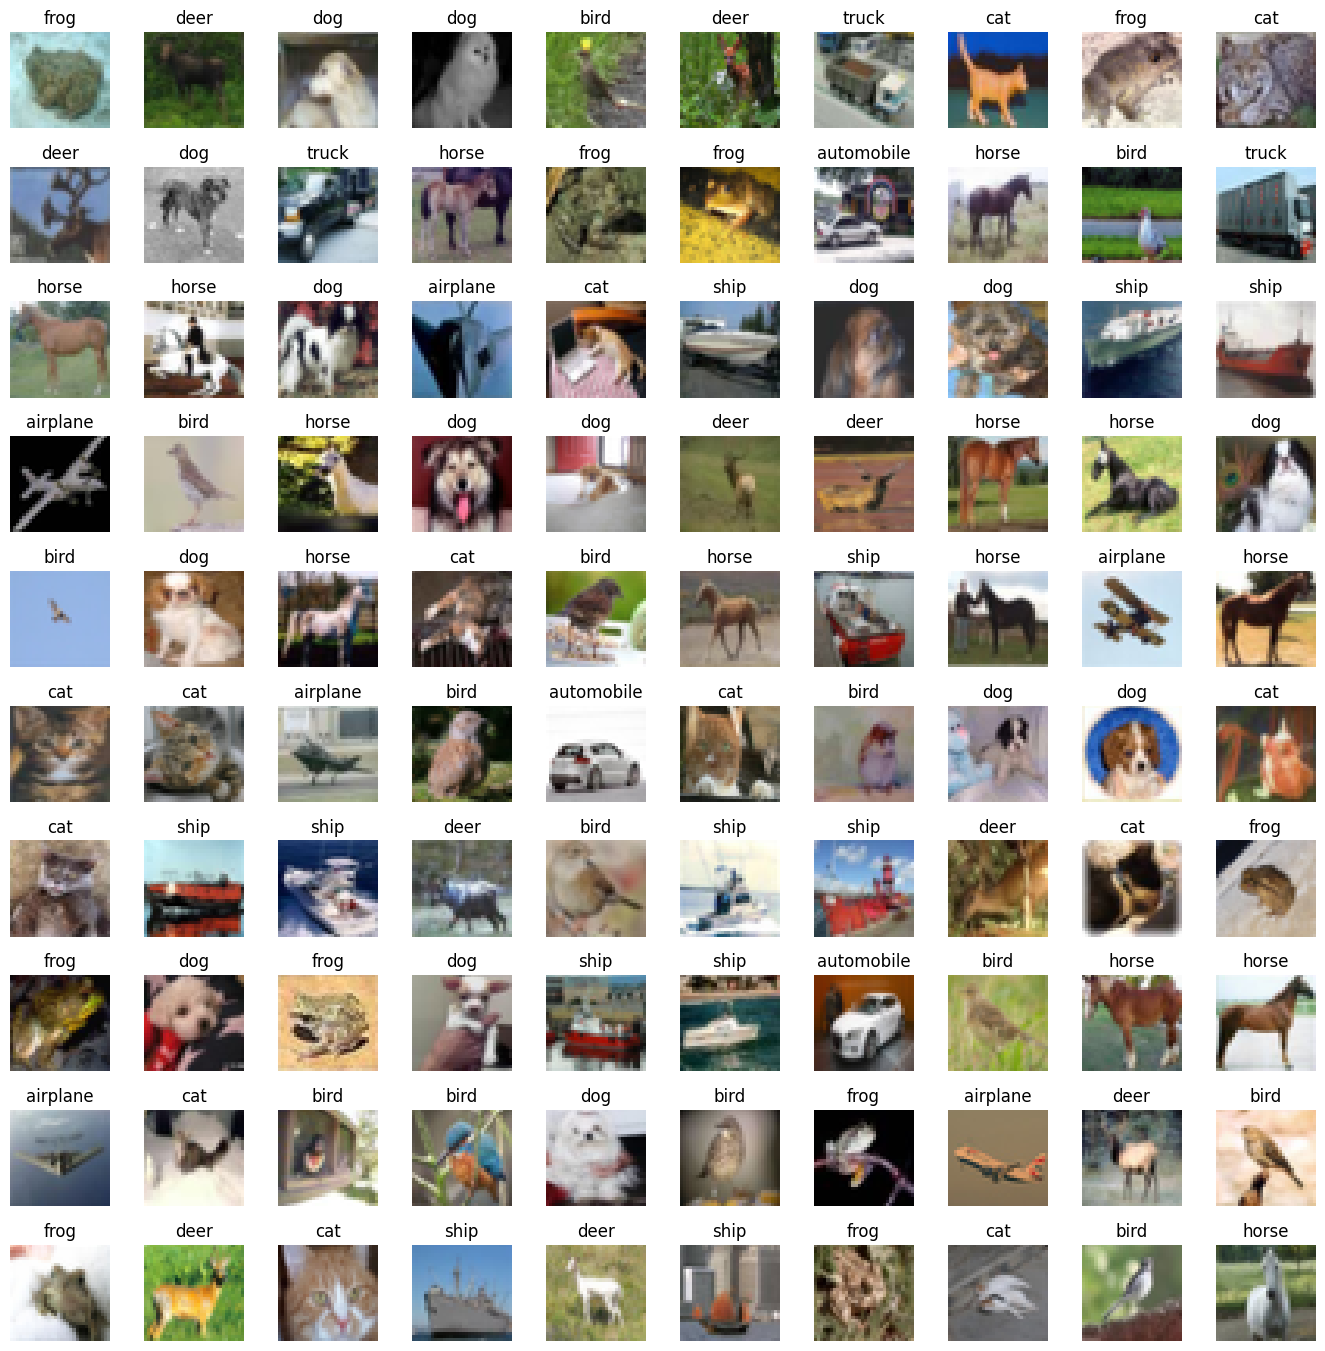

In [5]:
# Visualise sample images in a grid format
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(10, 10, figsize = (17, 17))

axes = axes.ravel()
n_train = len(X_train)

for i in np.arange(0, 100):
    index = np.random.randint(0, n_train)
    axes[i].imshow(X_train[index, 1:])
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index])
    axes[i].axis('off')

plt.subplots_adjust(hspace = 0.4)

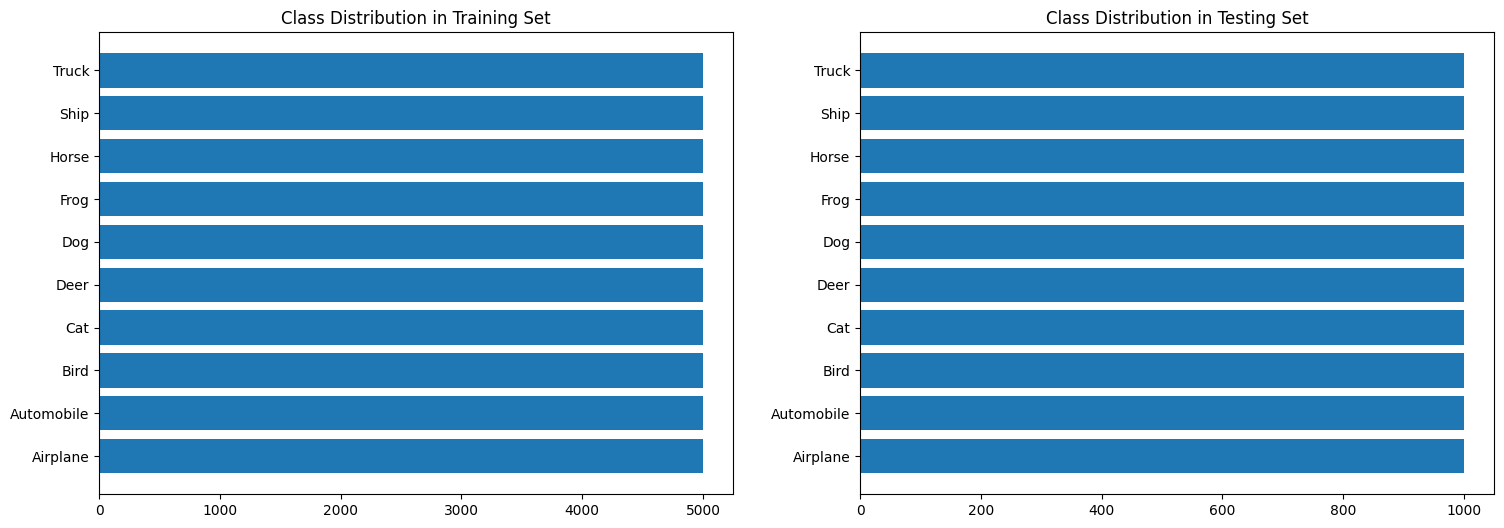

In [6]:
# Data visulization of class count in training and test datasets
classes_name = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
figure, axis = plt.subplots(1, 2, figsize = (18, 6))

classes, counts = np.unique(y_train, return_counts = True)
axis[0].barh(classes_name, counts)
axis[0].set_title('Class Distribution in Training Set')

classes, counts = np.unique(y_test, return_counts = True)
axis[1].barh(classes_name, counts)
axis[1].set_title('Class Distribution in Testing Set')

plt.show()

## Data Preprocessing

In [7]:
# Scale the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Transform target variable into one-hotencoding
y_cat_train = to_categorical(y_train, 10)
y_cat_test = to_categorical(y_test, 10)

## Model Building

In [8]:
# Set hyperparameters
INPUT_SHAPE = (32, 32, 3)
KERNEL_SIZE = (3, 3)
BATCH_SIZE = 32
model = Sequential()

In [9]:
# Convolutional layer
model.add(Conv2D(filters = 32, kernel_size = KERNEL_SIZE, input_shape = INPUT_SHAPE, activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = KERNEL_SIZE, input_shape = INPUT_SHAPE, activation = 'relu', padding = 'same'))
model.add(BatchNormalization())

# Pooling and dropout layers
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = KERNEL_SIZE, input_shape = INPUT_SHAPE, activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = KERNEL_SIZE, input_shape = INPUT_SHAPE, activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size = KERNEL_SIZE, input_shape = INPUT_SHAPE, activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size = KERNEL_SIZE, input_shape = INPUT_SHAPE, activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

# Flatten and dropout layers
model.add(Flatten())
# model.add(Dropout(0.2))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation = 'softmax'))

In [10]:
# Compile the model
METRICS = ['accuracy', tf.keras.metrics.Precision(name = 'precision'),
           tf.keras.metrics.Recall(name = 'recall')
          ]

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',
              metrics = METRICS)

In [11]:
# Generate model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                        

## Data Augmentation

In [12]:
# Define early stop
early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)

In [13]:
# Augments training data and trains model with validation for 50 epochs
data_generator = ImageDataGenerator(width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True)

train_generator = data_generator.flow(X_train, y_cat_train, BATCH_SIZE)
steps_per_epoch = X_train.shape[0] // BATCH_SIZE

r = model.fit(train_generator, 
              epochs = 50,
              steps_per_epoch = steps_per_epoch,
              validation_data = (X_test, y_cat_test), 
#             callbacks = [early_stop],
#             batch_size = BATCH_SIZE,
              )

Epoch 1/50


2023-11-17 08:52:00.608096: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1562/1562 [==============================] - 47s 21ms/step - loss: 1.6208 - accuracy: 0.4133 - precision: 0.6230 - recall: 0.1995 - val_loss: 1.2818 - val_accuracy: 0.5382 - val_precision: 0.6703 - val_recall: 0.4225
Epoch 2/50
1562/1562 [==============================] - 31s 20ms/step - loss: 1.2174 - accuracy: 0.5707 - precision: 0.7363 - recall: 0.4058 - val_loss: 0.9807 - val_accuracy: 0.6593 - val_precision: 0.7930 - val_recall: 0.5443
Epoch 3/50
1562/1562 [==============================] - 31s 20ms/step - loss: 1.0302 - accuracy: 0.6413 - precision: 0.7753 - recall: 0.5130 - val_loss: 1.0466 - val_accuracy: 0.6464 - val_precision: 0.7800 - val_recall: 0.5310
Epoch 4/50
1562/1562 [==============================] - 31s 20ms/step - loss: 0.9368 - accuracy: 0.6783 - precision: 0.7943 - recall: 0.5642 - val_loss: 0.7981 - val_accuracy: 0.7273 - val_precision: 0.8060 - val_recall: 0.6545
Epoch 5/50
1562/1562 [==============================] - 30s 19ms/step - loss: 0.8551 - accuracy: 0.

## Model Evaluation

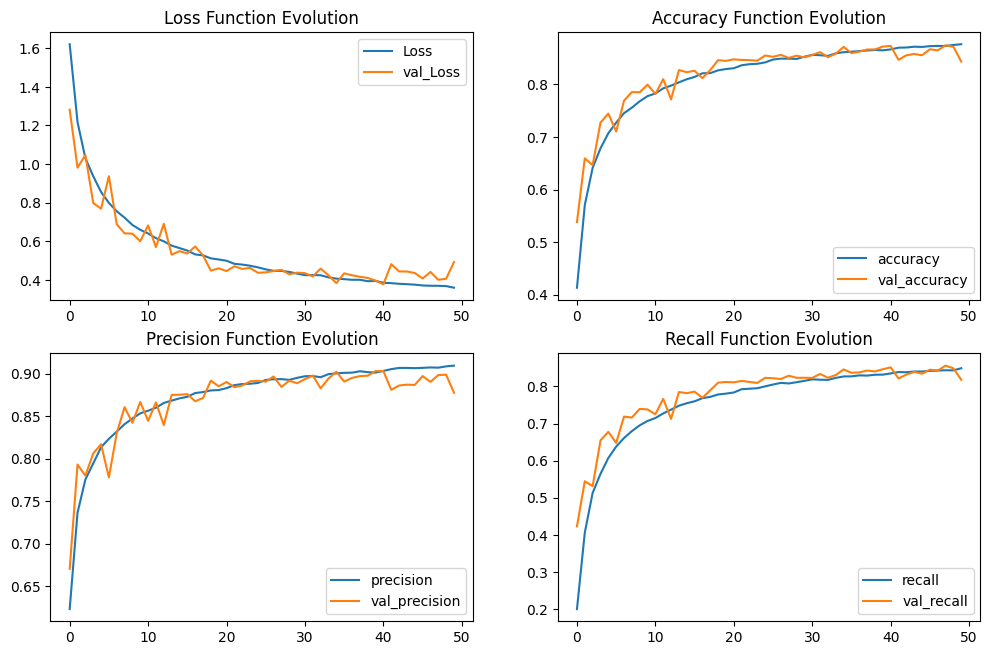

In [14]:
# Evolution graphs for loss, accuracy, precision, and recall functions
plt.figure(figsize = (12, 16))

plt.subplot(4, 2, 1)
plt.plot(r.history['loss'], label = 'Loss')
plt.plot(r.history['val_loss'], label = 'val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(r.history['precision'], label = 'precision')
plt.plot(r.history['val_precision'], label = 'val_precision')
plt.title('Precision Function Evolution')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(r.history['recall'], label = 'recall')
plt.plot(r.history['val_recall'], label = 'val_recall')
plt.title('Recall Function Evolution')
plt.legend()

313/313 [==============================] - 1s 4ms/step - loss: 0.4918 - accuracy: 0.8434 - precision: 0.8774 - recall: 0.8180
Test Accuracy : 84.34%
313/313 [==============================] - 1s 2ms/step


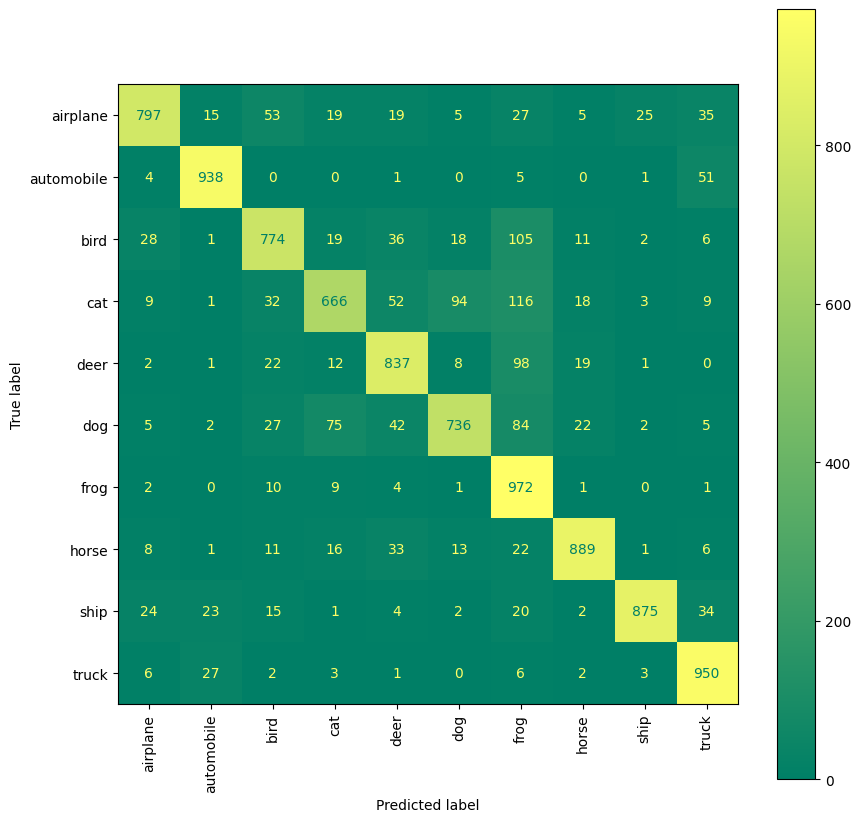

In [15]:
# Confusion Matrix visualisation
evaluation = model.evaluate(X_test, y_cat_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
cm = confusion_matrix(y_test, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = labels)


fig, ax = plt.subplots(figsize = (10, 10))
disp = disp.plot(xticks_rotation = 'vertical', ax = ax, cmap = 'summer')

plt.show()

In [16]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.80      0.85      1000
           1       0.93      0.94      0.93      1000
           2       0.82      0.77      0.80      1000
           3       0.81      0.67      0.73      1000
           4       0.81      0.84      0.83      1000
           5       0.84      0.74      0.78      1000
           6       0.67      0.97      0.79      1000
           7       0.92      0.89      0.90      1000
           8       0.96      0.88      0.91      1000
           9       0.87      0.95      0.91      1000

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



## Test the Model

We know that image 510 is [5].
1/1 [==============================] - 0s 21ms/step
The model predicts that image 510 is [5].


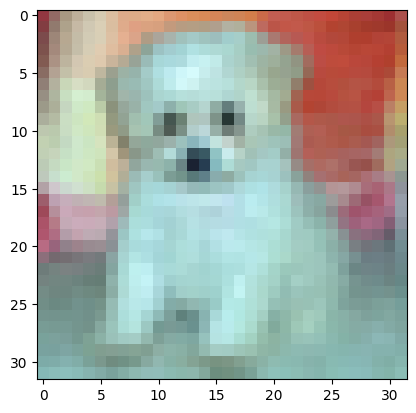

In [23]:
# Test on a random image
import random
img_num = random.randint(0, 1000)
my_image = X_test[img_num]
plt.imshow(my_image)

print(f"We know that image {img_num} is {y_test[img_num]}.")

pred_num = np.argmax(model.predict(my_image.reshape(1, 32, 32, 3)))
print(f"The model predicts that image {img_num} is [{pred_num}].")

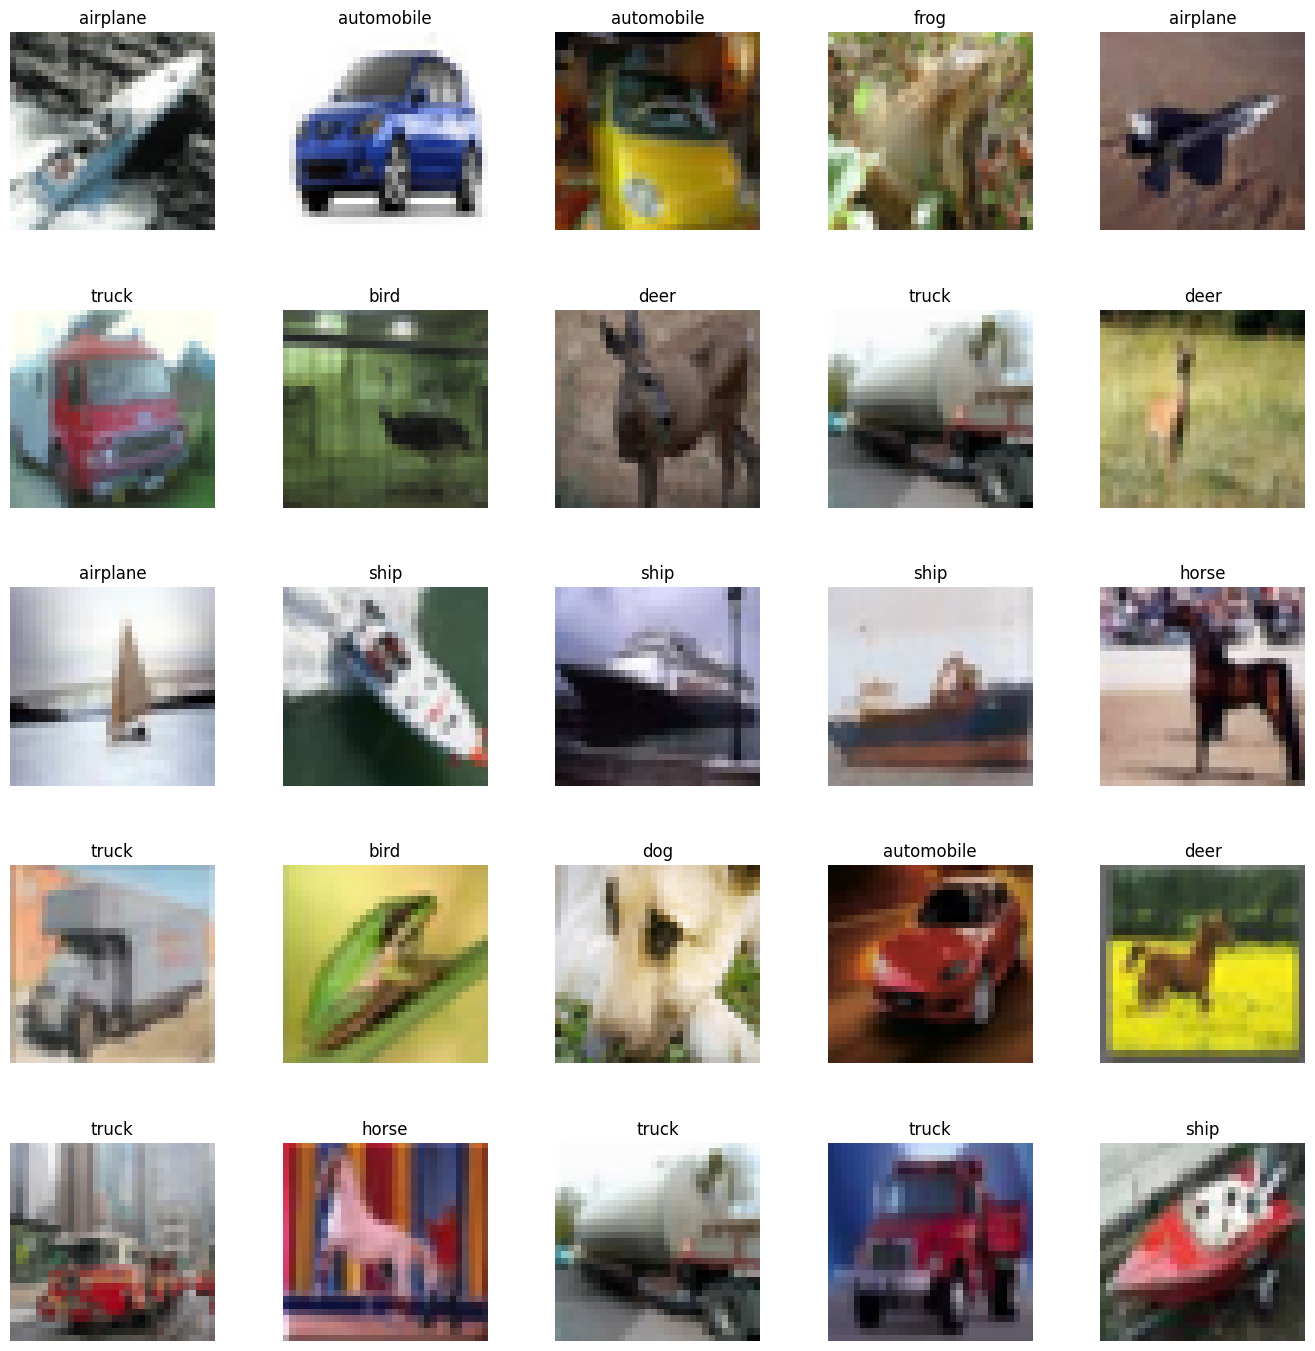

In [24]:
# Randomly display test images with predicted labels in a grid
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(5, 5, figsize = (17, 17))
axes = axes.ravel()
n_test = len(X_test)

for i in np.arange(0, 25):
    index = np.random.randint(0, n_test)
    axes[i].imshow(X_test[index, 1:])
    label_index = int(y_pred[index])
    axes[i].set_title(labels[label_index])
    axes[i].axis('off')

plt.subplots_adjust(hspace = 0.4)

In [25]:
# Plot image with predicted and true labels
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap = plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{labels[int(predicted_label)]} {100 * np.max(predictions_array):2.0f}% ({labels[int(true_label)]})", 
               color = color)

In [26]:
# Plot bar chart of prediction confidence
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, int(true_label[i])
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array)
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

313/313 [==============================] - 1s 2ms/step


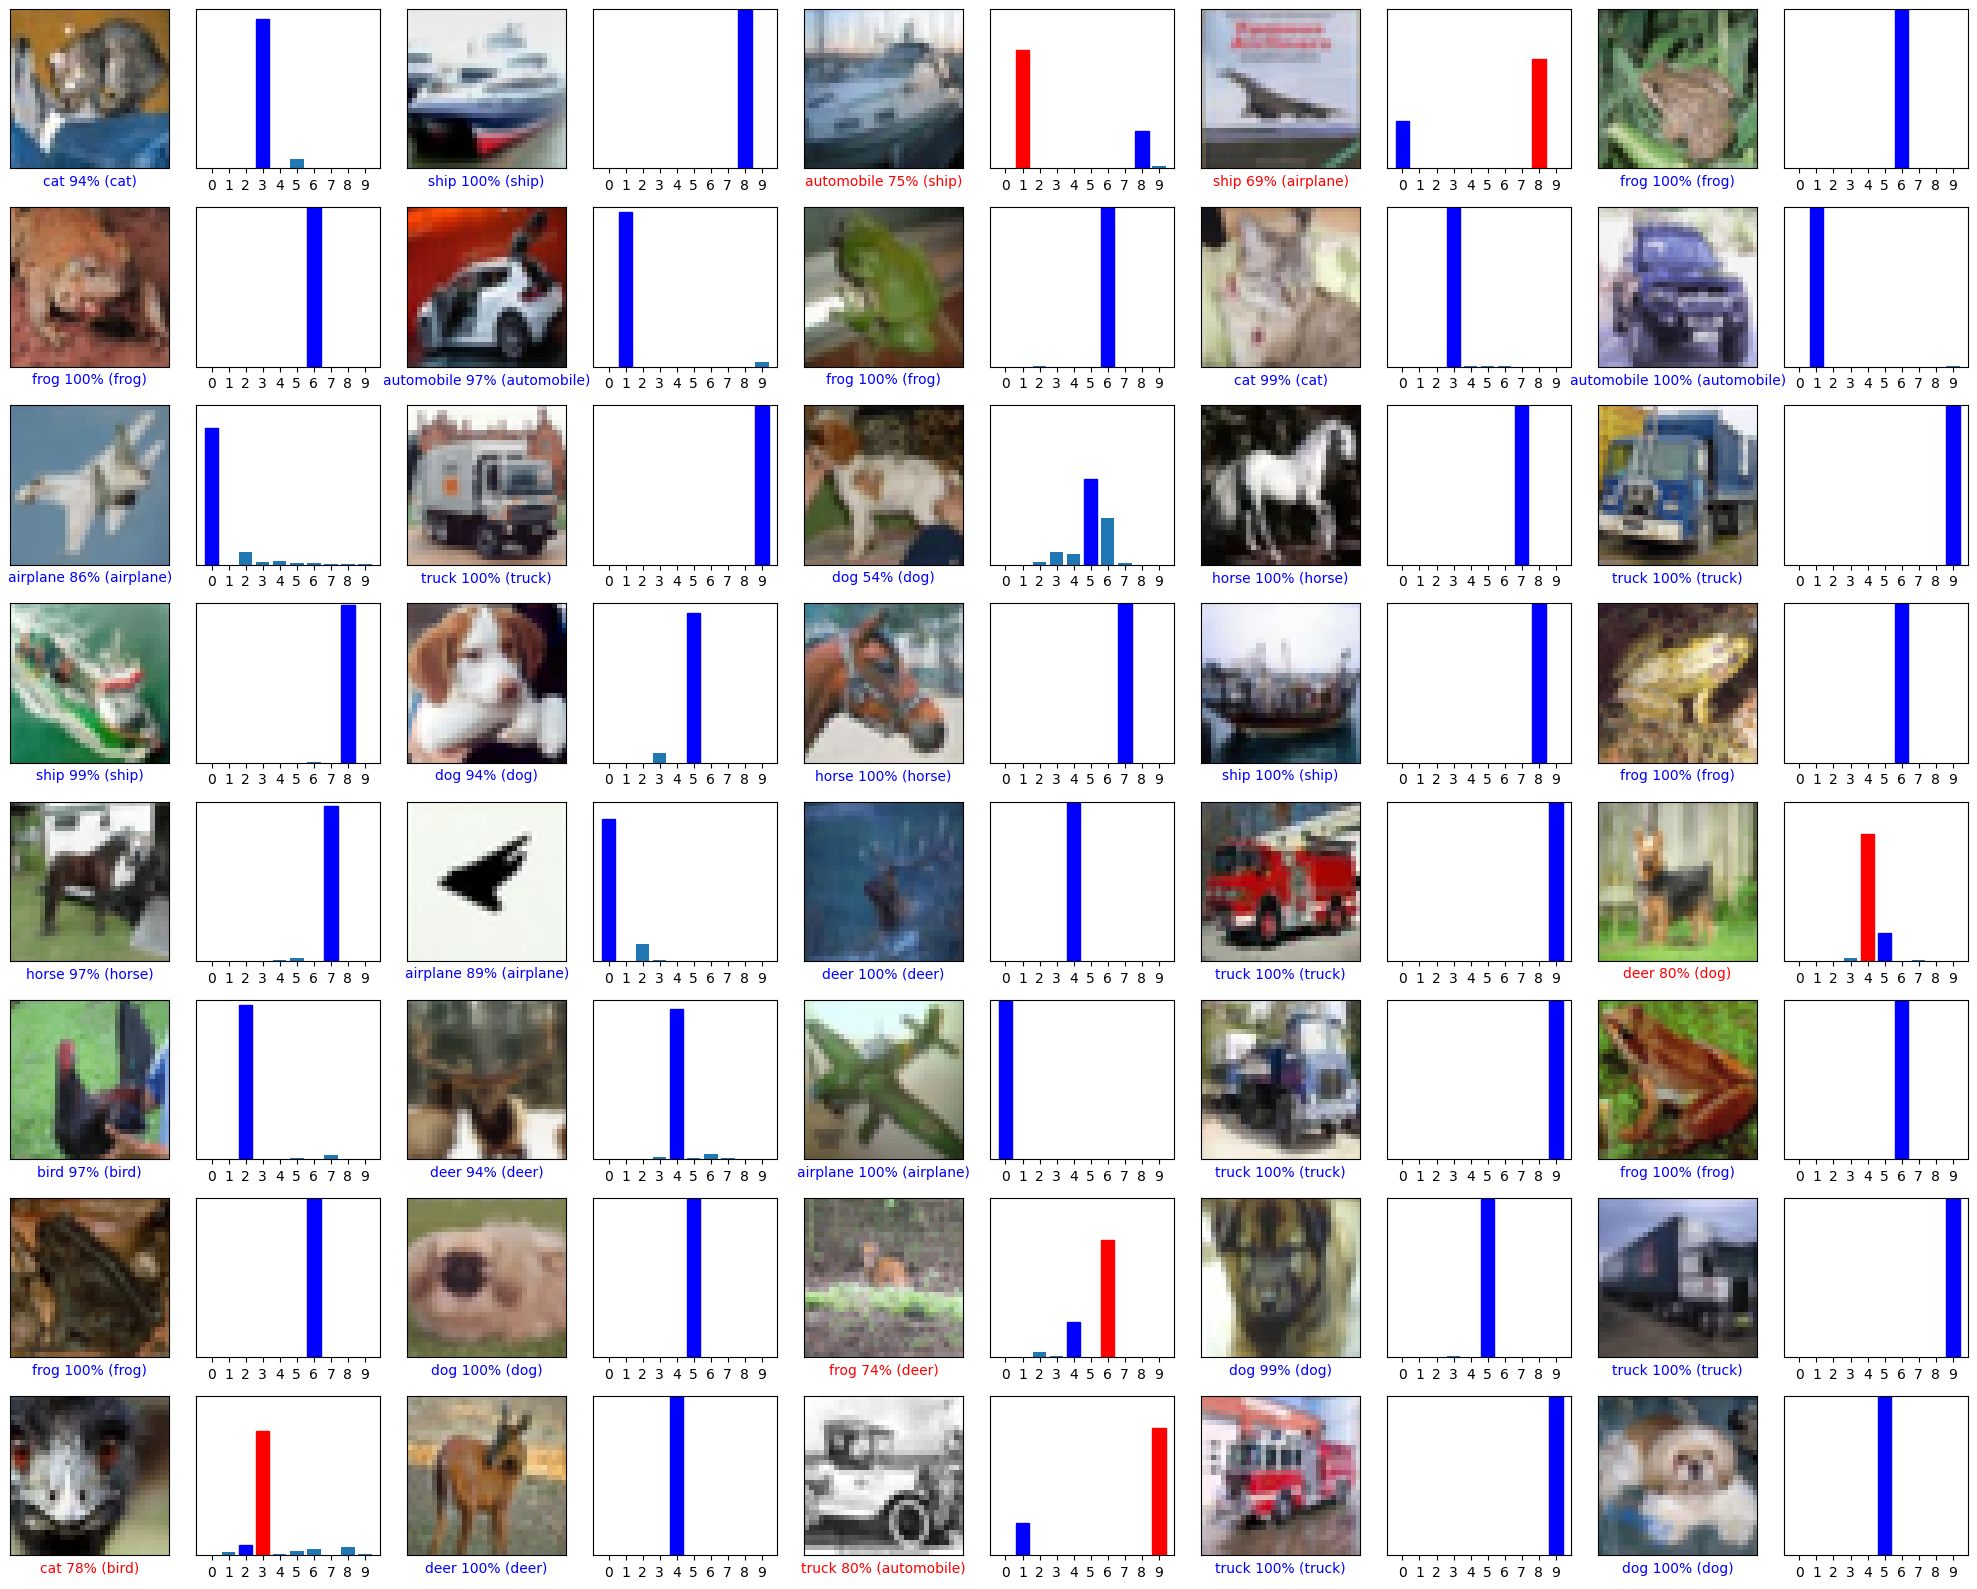

In [27]:
# Visualize model predictions for a subset of test images.
predictions = model.predict(X_test)
plt.figure(figsize=(20, 16))

for i in range(40):
    plt.subplot(8, 10, 2 * i + 1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplot(8, 10, 2 * i + 2)
    plot_value_array(i, predictions[i], y_test)

plt.tight_layout()
plt.show()